# Post-lapse Stability

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/fsrs4anki/blob/main/archive/research/post-lapse-stability.ipynb)

In [1]:
# Here are some settings that you need to replace before running this optimizer.

filename = "../../collection-2022-09-18@13-21-58.colpkg"
# If you upload deck file, replace it with your deck filename. E.g., ALL__Learning.apkg
# If you upload collection file, replace it with your colpgk filename. E.g., collection-2022-09-18@13-21-58.colpkg

# Replace it with your timezone. I'm in China, so I use Asia/Shanghai.
# You can find your timezone here: https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568
timezone = 'Asia/Shanghai'

# Replace it with your Anki's setting in Preferences -> Scheduling.
next_day_starts_at = 4

# Replace it if you don't want the optimizer to use the review logs before a specific date.
revlog_start_date = "2006-10-05"

# Set it to True if you don't want the optimizer to use the review logs from suspended cards.
filter_out_suspended_cards = False

In [2]:
import zipfile
import sqlite3
import time
import pandas as pd
import numpy as np
import os
from datetime import timedelta, datetime
from sklearn.metrics import mean_squared_error
from itertools import accumulate
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
tqdm.pandas()

In [3]:
"""Step 1"""
# Extract the collection file or deck file to get the .anki21 database.
with zipfile.ZipFile(f'{filename}', 'r') as zip_ref:
    zip_ref.extractall('./')
    print("Deck file extracted successfully!")

"""Step 2"""
if os.path.isfile("collection.anki21b"):
    os.remove("collection.anki21b")
    raise Exception(
        "Please export the file with `support older Anki versions` if you use the latest version of Anki.")
elif os.path.isfile("collection.anki21"):
    con = sqlite3.connect("collection.anki21")
elif os.path.isfile("collection.anki2"):
    con = sqlite3.connect("collection.anki2")
else:
    raise Exception("Collection not exist!")
cur = con.cursor()
res = cur.execute(f"""
SELECT *
FROM revlog
WHERE cid IN (
    SELECT id
    FROM cards
    {"WHERE queue != -1" if filter_out_suspended_cards else ""}
)
"""
)
revlog = res.fetchall()
if len(revlog) == 0:
    raise Exception("No review log found!")
df = pd.DataFrame(revlog)
df.columns = ['id', 'cid', 'usn', 'r', 'ivl', 'last_lvl', 'factor', 'time', 'type']
df = df[(df['cid'] <= time.time() * 1000) &
        (df['id'] <= time.time() * 1000)].copy()

df_set_due_date = df[(df['type'] == 4) & (df['ivl'] > 0)]
df.drop(df_set_due_date.index, inplace=True)

df['create_date'] = pd.to_datetime(df['cid'] // 1000, unit='s')
df['create_date'] = df['create_date'].dt.tz_localize('UTC').dt.tz_convert(timezone)
df['review_date'] = pd.to_datetime(df['id'] // 1000, unit='s')
df['review_date'] = df['review_date'].dt.tz_localize('UTC').dt.tz_convert(timezone)
df.drop(df[df['review_date'].dt.year < 2006].index, inplace=True)
df.sort_values(by=['cid', 'id'], inplace=True, ignore_index=True)

df['is_learn_start'] = (df['type'] == 0) & (df['type'].shift() != 0)
df['sequence_group'] = df['is_learn_start'].cumsum()
last_learn_start = df[df['is_learn_start']].groupby('cid')['sequence_group'].last()
df['last_learn_start'] = df['cid'].map(last_learn_start).fillna(0).astype(int)
df['mask'] = df['last_learn_start'] <= df['sequence_group']
df = df[df['mask'] == True].copy()
df.drop(columns=['is_learn_start', 'sequence_group', 'last_learn_start', 'mask'], inplace=True)
df = df[(df['type'] != 4)].copy()

type_sequence = np.array(df['type'])
time_sequence = np.array(df['time'])
df.to_csv("revlog.csv", index=False)
print("revlog.csv saved.")

df = df[(df['type'] != 3) | (df['factor'] != 0)].copy()
df['real_days'] = df['review_date'] - timedelta(hours=int(next_day_starts_at))
df['real_days'] = pd.DatetimeIndex(df['real_days'].dt.floor('D', ambiguous='infer', nonexistent='shift_forward')).to_julian_date()
df.drop_duplicates(['cid', 'real_days'], keep='first', inplace=True)
df['delta_t'] = df.real_days.diff()
df.dropna(inplace=True)
df['i'] = df.groupby('cid').cumcount() + 1
df.loc[df['i'] == 1, 'delta_t'] = 0
df = df.groupby('cid').filter(lambda group: group['type'].iloc[0] == 0)
df['prev_type'] = df.groupby('cid')['type'].shift(1).fillna(0).astype(int)
df['helper'] = ((df['type'] == 0) & ((df['prev_type'] == 1) | (df['prev_type'] == 2)) & (df['i'] > 1)).astype(int)
df['helper'] = df.groupby('cid')['helper'].cumsum()
df = df[df['helper'] == 0]
del df['prev_type']
del df['helper']

def cum_concat(x):
    return list(accumulate(x))

t_history = df.groupby('cid', group_keys=False)['delta_t'].apply(lambda x: cum_concat([[int(i)] for i in x]))
df['t_history']=[','.join(map(str, item[:-1])) for sublist in t_history for item in sublist]
r_history = df.groupby('cid', group_keys=False)['r'].apply(lambda x: cum_concat([[i] for i in x]))
df['r_history']=[','.join(map(str, item[:-1])) for sublist in r_history for item in sublist]
df = df.groupby('cid').filter(lambda group: group['id'].min() > time.mktime(datetime.strptime(revlog_start_date, "%Y-%m-%d").timetuple()) * 1000)
df['y'] = df['r'].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
df.to_csv('revlog_history.tsv', sep="\t", index=False)

Deck file extracted successfully!
revlog.csv saved.


In [4]:
from scipy.optimize import curve_fit

df_analysis = df[(df['i'] > 1) & (df['delta_t'] > 0) & (df['t_history'].str.count(',0') == 0)].copy()


df_analysis['retention'] = df_analysis.groupby(by=['r_history', 't_history', 'delta_t'], group_keys=False)['y'].transform('mean')
df_analysis['total_cnt'] = df_analysis.groupby(by=['r_history', 't_history', 'delta_t'], group_keys=False)['id'].transform('count')
df_analysis.drop(columns=['id', 'cid', 'usn', 'r', 'ivl', 'last_lvl', 'factor', 'time', 'type', 'create_date', 'review_date', 'real_days', 'y'], inplace=True)
df_analysis.drop_duplicates(inplace=True)
df_analysis.sort_values(by=['r_history', 't_history', 'delta_t'], inplace=True)
df_analysis

,delta_t,i,t_history,r_history,retention,total_cnt
275,1.0,2,0,1,0.893817,1488
5111,2.0,2,0,1,0.872222,360
218,3.0,2,0,1,0.790909,110
345,4.0,2,0,1,0.800000,50
396,5.0,2,0,1,0.707317,41
...,...,...,...,...,...,...
38515,43.0,5,"0,1,4,12","4,4,4,4",1.000000,1
7968,139.0,5,"0,4,12,38","4,4,4,4",1.000000,1
38516,122.0,6,"0,1,4,12,43","4,4,4,4,3",1.000000,1
7969,410.0,6,"0,4,12,38,139","4,4,4,4,3",1.000000,1


In [5]:
def exp_curve(delta_t, S):
    return 0.9 ** (delta_t / S)

def reverse_exp_curve(delta_t, R):
    return np.log(0.9) / np.log(R) * delta_t

def pow_curve(delta_t, S):
    return (1 + delta_t / (9 * S)) ** -1

def reverse_pow_curve(delta_t, R):
    return delta_t / 9 / (1 / R - 1)

def fit_stability(delta_t, recall, cnt, curve_func, reverse_curve_func):
    try:
        params, _ = curve_fit(curve_func, delta_t, recall, sigma=1/cnt, bounds=((0.1), (3650)))
        return params[0]
    except Exception as e:
        print(e)
        return reverse_curve_func(delta_t.values, recall.values)[0]

In [6]:
df_pow_stability = df_analysis.groupby(by=['r_history', 't_history']).progress_apply(lambda group: fit_stability(group['delta_t'], group['retention'], group['total_cnt'], pow_curve, reverse_pow_curve)).reset_index()

  0%|          | 0/50077 [00:00<?, ?it/s]

In [7]:
df_test = pd.merge(df_analysis, df_pow_stability, on=['r_history', 't_history'], how='left').rename(columns={0: 'pow_stability'})

In [8]:
df_test['t_plus_delta_t'] = df_test['t_history'] + df_test['delta_t'].map(lambda x: "," + str(int(x)))

In [9]:
df_test['r_plus_1'] = df_test['r_history'] + ",1"

In [10]:
result = pd.merge(df_test, df_test, left_on=['t_history', 'r_history'], right_on=['t_plus_delta_t', 'r_plus_1'], suffixes=('_left', '_right'))

In [11]:
result.drop(columns=['t_plus_delta_t_left', 't_plus_delta_t_right', 'r_plus_1_left', 'r_plus_1_right'], inplace=True)

In [12]:
result.drop_duplicates(subset=['t_history_left', 'r_history_left'], inplace=True)

In [13]:
result

,delta_t_left,i_left,t_history_left,r_history_left,retention_left,total_cnt_left,pow_stability_left,delta_t_right,i_right,t_history_right,r_history_right,retention_right,total_cnt_right,pow_stability_right
0,1.0,3,"0,1","1,1",0.868421,114,0.796240,1.0,2,0,1,0.893817,1488,0.999465
5,1.0,3,"0,2","1,1",0.952381,21,0.757530,2.0,2,0,1,0.872222,360,0.999465
8,1.0,3,"0,24","1,1",1.000000,1,1825.050000,24.0,2,0,1,0.000000,1,0.999465
9,1.0,3,"0,3","1,1",0.818182,22,0.503067,3.0,2,0,1,0.790909,110,0.999465
11,1.0,3,"0,4","1,1",1.000000,9,3421.910660,4.0,2,0,1,0.800000,50,0.999465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7930,1.0,7,"0,1,4,14,36,96","4,4,4,3,3,1",1.000000,1,1825.050000,96.0,6,"0,1,4,14,36","4,4,4,3,3",0.000000,1,0.100007
7931,1.0,11,"0,1,4,14,36,96,1,3,8,23","4,4,4,3,3,1,3,3,3,1",1.000000,1,1825.050000,23.0,10,"0,1,4,14,36,96,1,3,8","4,4,4,3,3,1,3,3,3",0.000000,1,0.100000
7932,1.0,8,"0,1,4,13,35,98,281","4,4,4,3,3,3,1",0.000000,1,0.100000,281.0,7,"0,1,4,13,35,98","4,4,4,3,3,3",0.000000,1,0.100000
7933,2.0,9,"0,1,4,13,35,98,281,1","4,4,4,3,3,3,1,1",1.000000,1,2737.624412,1.0,8,"0,1,4,13,35,98,281","4,4,4,3,3,3,1",0.000000,1,0.100000


In [14]:
result[(result['total_cnt_left'] > 5) & (result['retention_left'] < 1)]

,delta_t_left,i_left,t_history_left,r_history_left,retention_left,total_cnt_left,pow_stability_left,delta_t_right,i_right,t_history_right,r_history_right,retention_right,total_cnt_right,pow_stability_right
0,1.0,3,"0,1","1,1",0.868421,114,0.796240,1.0,2,0,1,0.893817,1488,0.999465
5,1.0,3,"0,2","1,1",0.952381,21,0.757530,2.0,2,0,1,0.872222,360,0.999465
9,1.0,3,"0,3","1,1",0.818182,22,0.503067,3.0,2,0,1,0.790909,110,0.999465
13,1.0,3,"0,5","1,1",0.888889,9,0.852939,5.0,2,0,1,0.707317,41,0.999465
18,1.0,4,"0,1,1","1,1,1",0.750000,12,0.342164,1.0,3,"0,1","1,1",0.868421,114,0.796240
231,1.0,5,"0,1,1,3","1,1,3,1",0.909091,11,1.111111,3.0,4,"0,1,1","1,1,3",0.835821,67,1.686538
898,1.0,4,"0,1,1","1,3,1",0.833333,6,0.461739,1.0,3,"0,1","1,3",0.896104,77,4.151884
903,1.0,4,"0,1,3","1,3,1",0.883721,43,0.880955,3.0,3,"0,1","1,3",0.926407,693,4.151884
905,1.0,4,"0,1,4","1,3,1",0.909091,11,1.717149,4.0,3,"0,1","1,3",0.884058,138,4.151884
916,1.0,4,"0,2,3","1,3,1",0.857143,7,1.069518,3.0,3,"0,2","1,3",0.911392,158,3.357472


<Axes: xlabel='pow_stability_right', ylabel='pow_stability_left'>

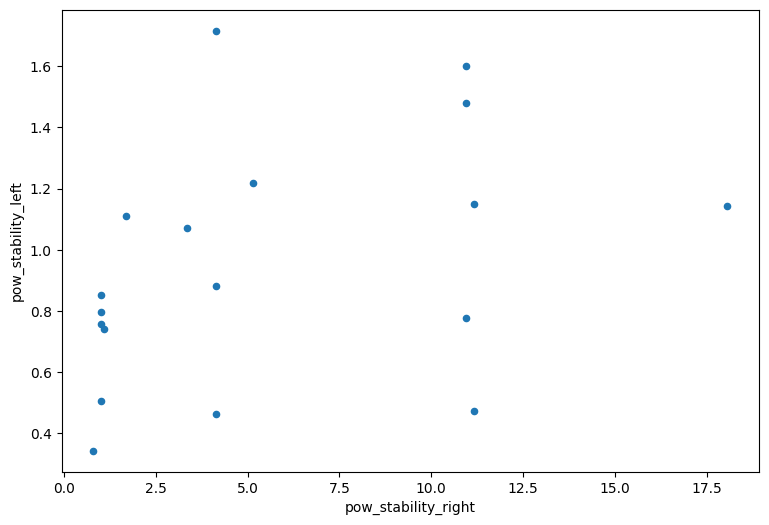

In [15]:
result[(result['total_cnt_left'] > 5) & (result['retention_left'] < 1)].plot.scatter(x='pow_stability_right', y='pow_stability_left', figsize=(9, 6))